We build on our previous XHMM experiences to start some real analysis.

In [16]:
import vcf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [5]:
# saving the important metrics from VCFs
vcf_reader = vcf.Reader(open('/data/NCR_SBRB/simplex/xhmm/DATA.vcf', 'r'))
SQs = {}
LQs = {}
RQs = {}
NQs = {}
for sample in vcf_reader.samples:
    SQs[sample] = []
    LQs[sample] = []
    RQs[sample] = []
    NQs[sample] = []
for record in vcf_reader:
    for sample in record.samples:
        SQs[sample.sample].append(sample.data.SQ)
        LQs[sample.sample].append(sample.data.LQ)
        RQs[sample.sample].append(sample.data.RQ)
        NQs[sample.sample].append(sample.data.NQ)

In [60]:
# figure out who is who in each trio

import glob
data_dir = '/data/NCR_SBRB/simplex/'
trios = {}
affected = []
controls = []
peds = glob.glob(data_dir + '*trio*ped')
for ped in peds:
    trio_name = ped.split('/')[-1].split('.')[0]
    fid = open(ped, 'r')
    fam = {}
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        if fa != '0':
            fam['child'] = sid
            if aff == '1':
                affected.append(trio_name)
            else:
                controls.append(trio_name)
        elif sex == '1':
            fam['father'] = sid
        else:
            fam['mother'] = sid
    trios[trio_name] = fam
    fid.close()
    
fid = open('/data/NCR_SBRB/simplex/famids.txt', 'r')
fams = [t.rstrip() for t in fid]
fid.close()

Just because CCGO_800976 was removed during sample filtering step in XHMM, let's remove the family that has that sample, as it's a father

In [61]:
del trios['10369_trio1']
del trios['10369_trio2']
fams.remove('10369')

Now we calculate which CNVs are inherited and which ones are denovo, per child:

In [55]:
quality = np.arange(10, 100, 10)
ntrios = len(trios)
trans_rate = np.zeros([ntrios, len(quality)])
denovo = np.zeros([ntrios, len(quality)])
disruptive_dnm = np.zeros([ntrios, len(quality)])
disruptive_inh = np.zeros([ntrios, len(quality)])
cnvs = np.zeros([ntrios, len(quality)])
for q, qual in enumerate(quality):
    qual_prime = qual / 2.0
    for t, trio in enumerate(trios.keys()):
        some_deletion = np.any(np.array(SQs[trios[trio]['child']]) >= qual,
                               axis=1)
        cnvs[t, q] = np.sum(some_deletion)
        
        # denovo criteria
        mom_diploid = np.any(np.array(NQs[trios[trio]['mother']]) >= qual,
                             axis=1)
        dad_diploid = np.any(np.array(NQs[trios[trio]['father']]) >= qual,
                             axis=1)
        child_dnms = np.logical_and(some_deletion,
                                    np.logical_and(mom_diploid, dad_diploid))
        denovo[t, q] = np.sum(child_dnms)
        
        # transmitted criteria
        mom_deletion = np.any(np.array(SQs[trios[trio]['mother']]) >= qual,
                              axis=1)
        mom_source = np.logical_and(mom_deletion, dad_diploid)
        dad_deletion = np.any(np.array(SQs[trios[trio]['father']]) >= qual,
                              axis=1)
        dad_source = np.logical_and(dad_deletion, mom_diploid)
        transmitted = np.logical_or(np.logical_and(mom_source, some_deletion),
                                    np.logical_and(dad_source, some_deletion))
        
        child_diploid = np.any(np.array(NQs[trios[trio]['child']]) >= qual,
                               axis=1)
        not_transmitted = np.logical_or(np.logical_and(mom_source,
                                                       child_diploid),
                                        np.logical_and(dad_source,
                                                       child_diploid))
        trans_rate[t, q] = float(np.sum(transmitted)) / (np.sum(transmitted) +
                                                         np.sum(not_transmitted))
        
        # disruptive criteria
        good_left = np.any(np.array(LQs[trios[trio]['child']]) >= qual_prime,
                           axis=1)
        good_right = np.any(np.array(RQs[trios[trio]['child']]) >= qual_prime,
                            axis=1)
        idx = np.logical_and(child_dnms, np.logical_or(good_left, good_right))
        disruptive_dnm[t, q] = np.sum(idx) 
        idx = np.logical_and(transmitted, np.logical_or(good_left, good_right))
        disruptive_inh[t, q] = np.sum(idx)

([<matplotlib.axis.XTick at 0x2aab08907b10>,
 <a list of 9 Text xticklabel objects>)

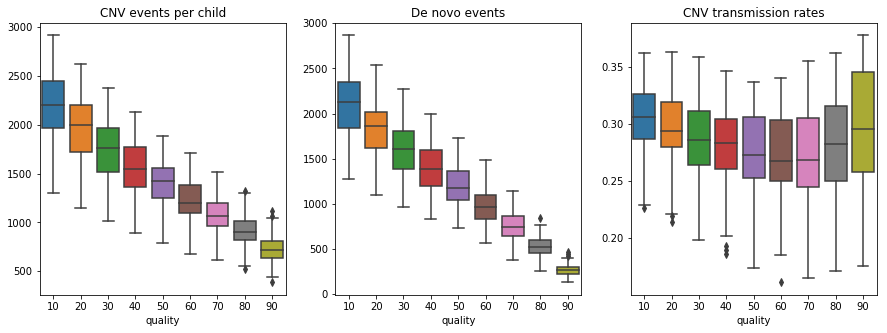

In [56]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=[cnvs[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV events per child')
plt.xticks(range(len(quality)), quality)

plt.subplot(1, 3, 2)
sns.boxplot(data=[denovo[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('De novo events')
plt.xticks(range(len(quality)), quality)

plt.subplot(1, 3, 3)
sns.boxplot(data=[trans_rate[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV transmission rates')
plt.xticks(range(len(quality)), quality)

Comparing to the numbers they get in the paper (below), we're still a bit high. We might need to recalibrate the HMM parameters. ut let's do some counting just in case. These numbers might change as well, if we do simplex ADHD vs multiplex ADHD.

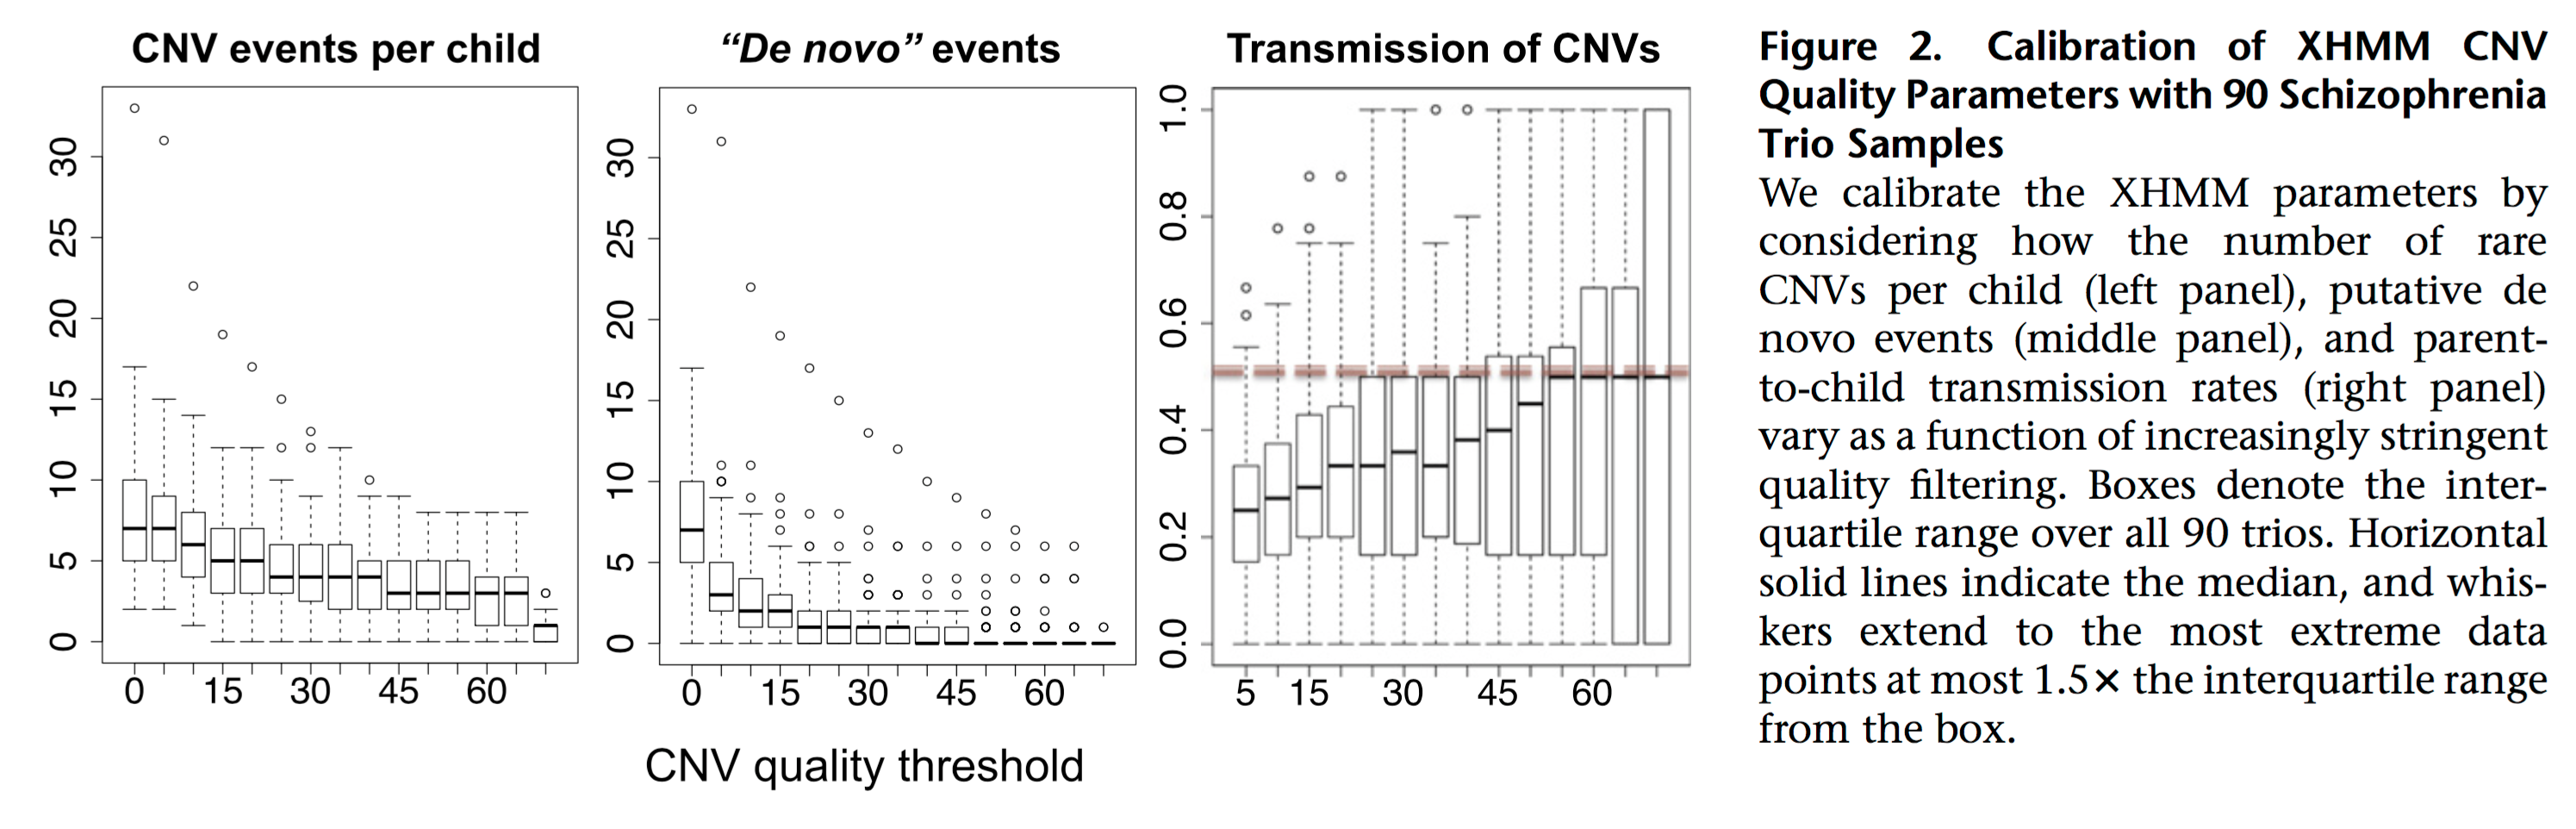

Now that we have the total number of CNV events for each child in the trios, let's see if ADHD trios have more disruptive denovo CNVs:

In [102]:
quality = np.arange(10, 100, 10)
from scipy import stats
rel_ps = []
wilcoxon_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            x.append(disruptive_dnm[k[0], q])
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[1]]
            y.append(disruptive_dnm[k[0], q])
    stat, pval = stats.wilcoxon(x, y)
    wilcoxon_ps.append(pval)
    stat, pval = stats.ttest_rel(x, y)
    rel_ps.append(pval)
print 'Only one pair per family:'
print 'Nonparametric:', wilcoxon_ps
print 'T-test:', rel_ps

ttest_ps = []
mann_ps = []
for q, qual in enumerate(quality):
    x, y = [], []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            x.append(disruptive_dnm[k[0], q])
            for mykey in keys[1:]:
                k = [k for k in range(len(trios.keys())) if trios.keys()[k] == mykey]
                y.append(disruptive_dnm[k[0], q])
    stat, pval = stats.mannwhitneyu(x, y)
    mann_ps.append(pval)
    stat, pval = stats.ttest_ind(x, y)
    ttest_ps.append(pval)
print 'All pairs:'
print 'Non-parametric:', mann_ps
print 'T-test:', ttest_ps

Only one pair per family:
Nonparametric: [0.076617923411671229, 0.09895736546518985, 0.053381693795433491, 0.083556366675359581, 0.015744918061158977, 0.09895736546518985, 0.23083797729318389, 0.6718457591814988, 0.81566948168670828]
T-test: [0.12114283468277119, 0.14165326757722987, 0.15747920602946613, 0.14885467643601427, 0.042810613197599136, 0.11830101187146599, 0.25456737758267922, 0.66039454433414346, 0.81102076118217037]
All pairs:
Non-parametric: [0.0015021389639176188, 0.0024690861266237134, 0.0053161792188013571, 0.0039621291626596175, 0.0034688149844888301, 0.023506220380767721, 0.12280495324816437, 0.2477370513284437, 0.33814781343957145]
T-test: [0.0051830310201807428, 0.0076745657765498604, 0.011655789545576316, 0.012449679060159362, 0.0025079074789118591, 0.016613011694632654, 0.12871345409093049, 0.39978590707826001, 0.55992126447574009]


Some interesting results... let's plot their means to see if they make sense:

In [87]:
quality = np.arange(10, 100, 10)
means = np.zeros([3, len(quality)])
for q, qual in enumerate(quality):
    aff = []
    unaff_pair = []
    unaff_all = []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            aff.append(disruptive_dnm[k[0], q])
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[1]]
            unaff_pair.append(disruptive_dnm[k[0], q])
            for mykey in keys[1:]:
                k = [k for k in range(len(trios.keys())) if trios.keys()[k] == mykey]
                unaff_all.append(disruptive_dnm[k[0], q])
    means[0, q] = np.mean(aff)
    means[1, q] = np.mean(unaff_pair)
    means[2, q] = np.mean(unaff_all)

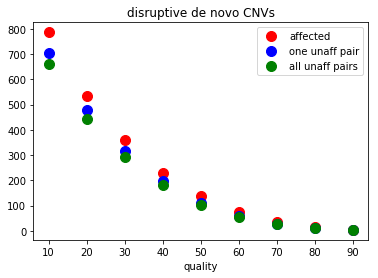

In [100]:
plt.figure()
plt.plot(quality, means[0, :], '.', color='r', markersize=20)
plt.plot(quality, means[1, :], '.', color='b', markersize=20)
plt.plot(quality, means[2, :], '.', color='g', markersize=20)
plt.legend(['affected', 'one unaff pair', 'all unaff pairs'])
plt.xlabel('quality')
plt.title('disruptive de novo CNVs')

So, at least it's going in the right direction (affected has more disruptive CNVs).

**NOTE that I still need to check where the CNV lies with respect to genes, like what they did in the paper!**

But for now, we could pick on threshold and analyze the CNVs Or, try the method of removing the CNV if it's in any of the unaffected trios. Then, we can use a plot like that mostly to show that the result holds across quality thresholds.

In [103]:
q = 5
print 'P-vals at quality %d:' % quality[q], ttest_ps[q], mann_ps[q], rel_ps[q], wilcoxon_ps[q]

P-vals at quality 60: 0.0166130116946 0.0235062203808 0.118301011871 0.0989573654652


**Also note that I'll need to re-run all this analysis after re-running the GATK pipeline, after Sijung and Tri started using Trimmomatic!**

Hopefully the results won't change much, but maybe let's not run too much on it, so we don't have to re-run everything again.

# TODO:

* better to run PCA within groups? are controls biasing the results? check literature. might need ot run other tools instead
* number of rare denovo CNVs present only in affected trio, and compare it to numbers only in unaffected trio!
* check different parameters in HMM to end up with less CNVs
* "require that the CNV breakpoint with high certainty actually falls within a gene transcript and not at the edge of the gene"
* if we add the brain to this, instead of doing nv vs adhd contrast, could we do brain correlations?
* incorporate multiplex samples in the analysis